# Predicting Amazon's stock price

Our objective is to predict stock price given 9 previous days closing price. 

The following sequence of code will prepare our data for analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

np.random.seed(67)
tf.random.set_seed(67)

epoch_num = 30 # this needs to be set much higher if we are to get a good model -- but, higher number of epochs takes more training time

2024-04-18 13:40:17.415088: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Collect and prepare data for analysis

In [2]:
df = pd.read_csv('AMZN.csv',  parse_dates=True)

In [3]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [4]:
df = df[['Close']]

In [5]:
df

,Close
0,102.510002
1,102.739998
2,102.300003
3,104.300003
4,103.809998
...,...
246,185.190002
247,185.669998
248,185.949997
249,189.050003


In [6]:
df['Close'].isna().sum()

0

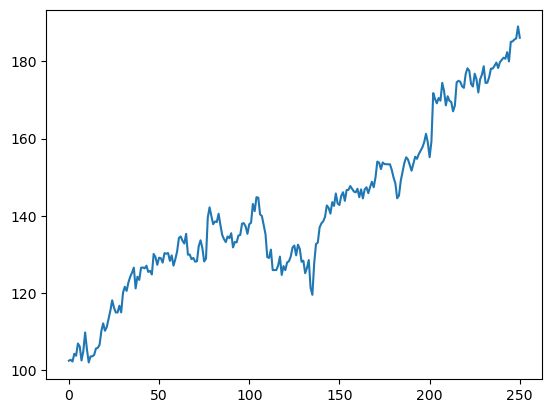

In [7]:
#Plot stock

plt.plot(df)
plt.show()

In [8]:
row_count = df.shape[0] # store the number of obersvations (daily closing price)
row_count

251

In [9]:
type(df)

pandas.core.frame.DataFrame

In [10]:
stock_price = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of stock price
stock_price.shape

(251, 1)

In [11]:
type(stock_price)

numpy.ndarray

> NOTE: Our objective is to predict stock price given 9 previous days closing price. In the next few cells, we create a 'sliding window' of stock price data. This is a common technique in time series analysis. The idea is to use a window of 'n' days to predict the stock price on the 'n+1' day. In this case, we are using 9 days to predict the 10th day. This is a simple example, but the concept is used in many more complex time series models.
>


In [12]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [13]:
stock_price = stock_price[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
stock_price.shape

(250, 1)

In [14]:
stock_price = stock_price.reshape(row_count // sequence_length, sequence_length) # note that stock_price are a multiple of sequence length, we can split the data into rows of sequence length.
stock_price

array([[102.739998, 102.300003, 104.300003, 103.809998, 106.959999,
        106.209999, 102.57    , 104.980003, 109.82    , 105.449997],
       [102.050003, 103.629997, 103.650002, 104.      , 105.660004,
        105.830002, 106.620003, 110.190002, 112.18    , 110.260002],
       [111.199997, 113.400002, 115.5     , 118.150002, 116.25    ,
        115.010002, 114.989998, 116.75    , 115.      , 120.110001],
       [121.660004, 120.580002, 122.769997, 124.25    , 125.300003,
        126.610001, 121.230003, 124.25    , 123.43    , 126.57    ],
       [126.660004, 126.419998, 127.110001, 125.489998, 125.779999,
        124.830002, 130.149994, 129.330002, 127.330002, 129.179993],
       [129.039993, 127.900002, 130.360001, 130.220001, 130.380005,
        128.360001, 129.779999, 127.129997, 128.779999, 130.800003],
       [134.300003, 134.679993, 133.559998, 132.830002, 135.360001,
        129.960007, 130.      , 128.800003, 129.130005, 128.149994],
       [128.25    , 132.210007, 133.67999

In [15]:
# create our X and y. 
# X will be the 9 days prior...
X = stock_price[:, :-1] # all rows, all columns except the last one
# y will be the 10th day (what we are trying to predict)
y = stock_price[:, -1] # all rows, only the last column

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(17, 9, 1)
(8, 9, 1)


## MODEL01 - Simple RNN with one layer

In [18]:

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(64,  activation= 'relu', input_shape=[n_steps, n_inputs]),
        Dense(1, activation= None)
    ]
)
model.summary()

/Users/xuesehuanghun/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 14316.7861 - root_mean_squared_error: 119.6528 - val_loss: 11662.3584 - val_root_mean_squared_error: 107.9924
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 12839.2061 - root_mean_squared_error: 113.3102 - val_loss: 10752.3438 - val_root_mean_squared_error: 103.6935
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 11832.1953 - root_mean_squared_error: 108.7759 - val_loss: 10003.1406 - val_root_mean_squared_error: 100.0157
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 11017.3662 - root_mean_squared_error: 104.9636 - val_loss: 9268.5684 - val_root_mean_squared_error: 96.2734
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 10219.2148 - root_mean_squared_error: 101.0901 - val_loss: 8515.3906 - val_root_mean_squared_error: 92.2789
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 9397.1777 - root_mean_squared_error: 96.9390 - val_loss: 7732.9126 - val_root_mean_squared_error: 87.9370
Epo

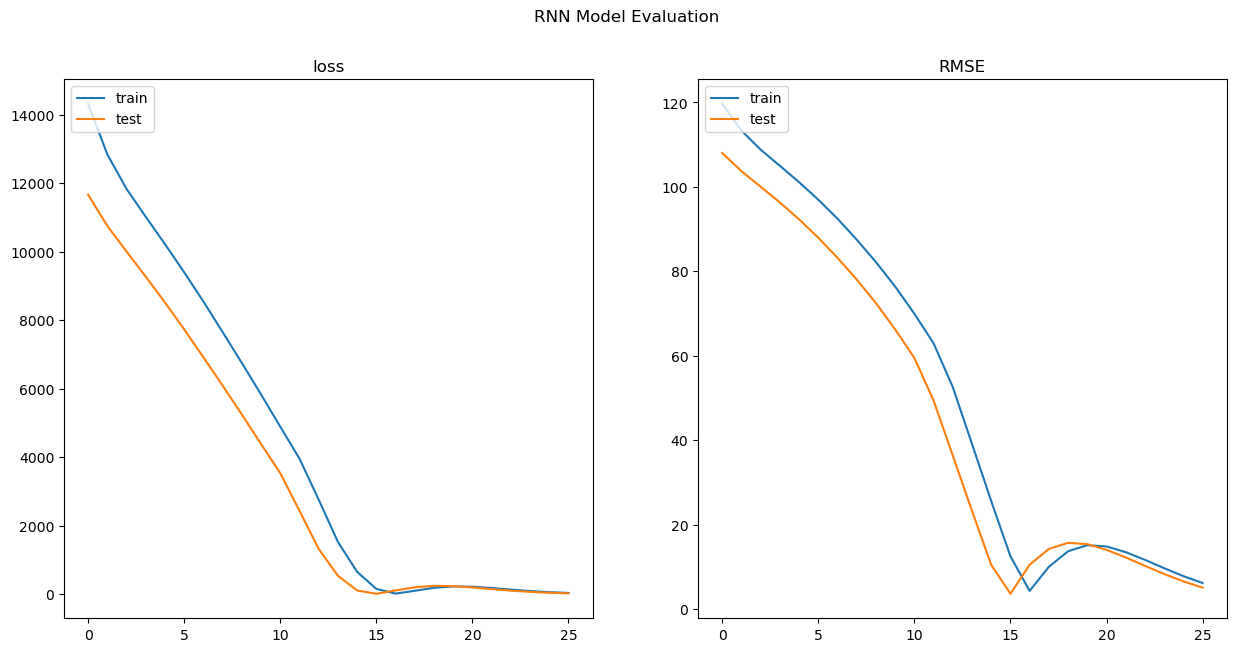

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

> NOTE: We can see by the above diagrams that more training would be beneficial. However, the training time is quite long. For this in-class example, I've kept the training time short. However, for a real-world application, we would want to train for a longer period of time.

In [22]:
from sklearn.metrics import mean_squared_error

#Predict:
y_pred = model.predict(X_test)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step


array([[147.21416],
       [157.74146],
       [107.91665],
       [180.07732],
       [134.48618],
       [130.74828],
       [162.6295 ],
       [119.04757]], dtype=float32)

In [23]:
mean_squared_error(y_test, y_pred)**0.5

5.054470690275387

Now, let's say our past 9 days of temperatures were as follow....

In [24]:
prior_days = np.array(
    [
        180.690002,182.410004,180,185.070007,185.190002,185.669998,185.949997,189.050003,186.130005, 
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 9, 1) # 1 row, 9 time steps (features), and 1 output/prediction)

In [25]:
model.predict(prior_days) # note the structure of the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


array([[190.8283]], dtype=float32)

In [26]:
tomorrows_stock_price = model.predict(prior_days)[0][0] # we see the predicted price is embedded inside two dimensions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [27]:
print(f"Tomorrow's predicted stock price is {tomorrows_stock_price:.2f} dollar.")

Tomorrow's predicted stock price is 190.83 dollar.


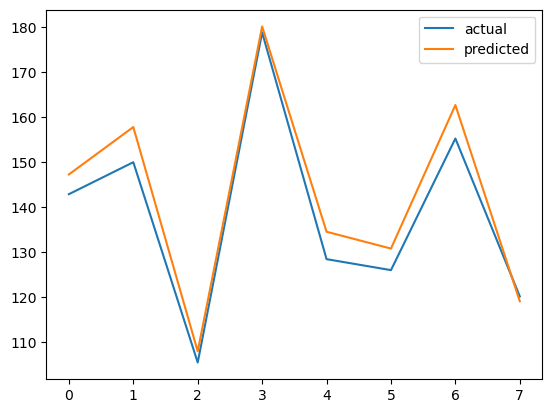

In [28]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

## MODEL02 - LSTM with one layer

In [29]:
n_steps = sequence_length - 1
n_inputs = 1


model = Sequential(
    [
        LSTM(64, activation='relu', input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()


/Users/xuesehuanghun/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 22545.5469 - root_mean_squared_error: 150.1517 - val_loss: 19578.3945 - val_root_mean_squared_error: 139.9228
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 21492.0410 - root_mean_squared_error: 146.6016 - val_loss: 18787.0781 - val_root_mean_squared_error: 137.0660
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 20640.6230 - root_mean_squared_error: 143.6684 - val_loss: 17451.9648 - val_root_mean_squared_error: 132.1059
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - loss: 19216.2266 - root_mean_squared_error: 138.6226 - val_loss: 11680.4707 - val_root_mean_squared_error: 108.0762
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 12949.2773 - root_mean_squared_error: 113.7949 - val_loss: 8645.8594 - val_root_mean_squared_error: 92.9831
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 9705.6602 - root_mean_squared_error: 98.5173 - val_loss: 6908.4175 - val_root_mean_squared_error: 83.1169
Epoch

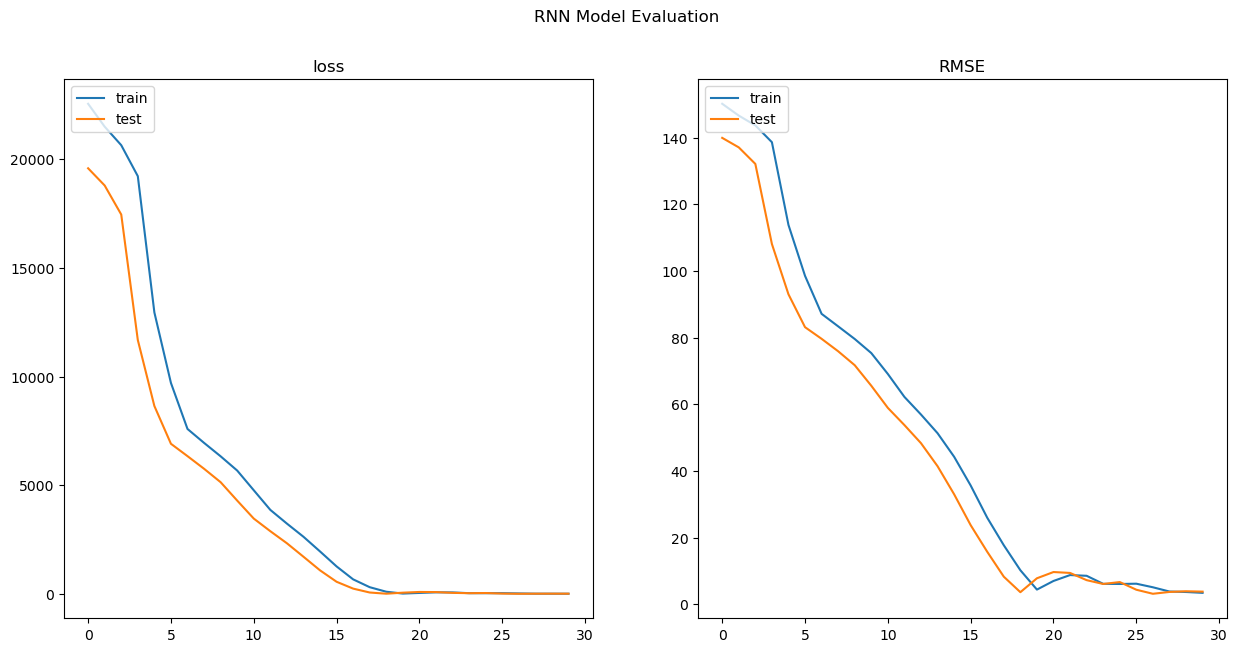

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [33]:
from sklearn.metrics import mean_squared_error

#Predict:
y_pred = model.predict(X_test)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


array([[145.40138 ],
       [153.26112 ],
       [105.722115],
       [172.1111  ],
       [131.99504 ],
       [127.44952 ],
       [160.19977 ],
       [116.77271 ]], dtype=float32)

In [34]:
mean_squared_error(y_test, y_pred)**0.5

3.7605802060481412

In [35]:
prior_days = np.array(
    [
        180.690002,182.410004,180,185.070007,185.190002,185.669998,185.949997,189.050003,186.130005, 
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 9, 1) # 1 row, 9 time steps (features), and 1 output/prediction)

In [36]:
model.predict(prior_days) # note the structure of the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


array([[186.85162]], dtype=float32)

In [37]:
tomorrows_stock_price = model.predict(prior_days)[0][0] # we see the predicted price is embedded inside two dimensions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [38]:
print(f"Tomorrow's predicted stock price is {tomorrows_stock_price:.2f} dollar.")

Tomorrow's predicted stock price is 186.85 dollar.


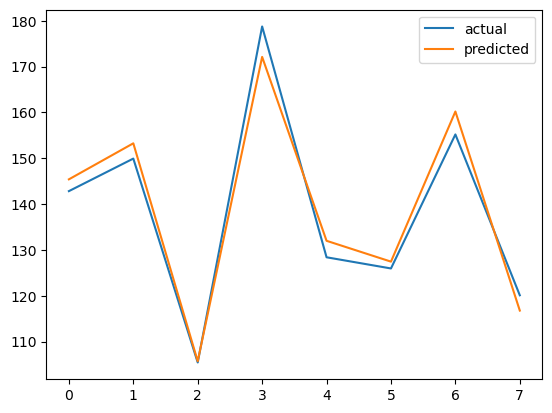

In [39]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

## MODEL03 - GRU with more layer

In [40]:
n_steps = sequence_length - 1
n_inputs = 1


model = Sequential(
    [
        GRU(64, return_sequences=True, input_shape=[n_steps, n_inputs], activation= 'relu'),
        GRU(64, return_sequences=True, activation= 'relu'),
        GRU(64, activation= 'relu'),
        Dense(1, activation=None)
    ]
)
model.summary()

/Users/xuesehuanghun/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 9, 64)          │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 9, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,849 (245.50 KB)

 Trainable params: 62,849 (245.50 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [42]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 20968.6699 - root_mean_squared_error: 144.8056 - val_loss: 18554.2324 - val_root_mean_squared_error: 136.2139
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 20353.6504 - root_mean_squared_error: 142.6662 - val_loss: 18132.5156 - val_root_mean_squared_error: 134.6570
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 19899.2520 - root_mean_squared_error: 141.0647 - val_loss: 17697.4219 - val_root_mean_squared_error: 133.0317
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 19428.9473 - root_mean_squared_error: 139.3878 - val_loss: 17207.4160 - val_root_mean_squared_error: 131.1770
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 18895.7539 - root_mean_squared_error: 137.4618 - val_loss: 16653.7988 - val_root_mean_squared_error: 129.0496
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 18295.7402 - root_mean_squared_error: 135.2617 - val_loss: 15999.5029 - val_root_mean_squared_error: 12

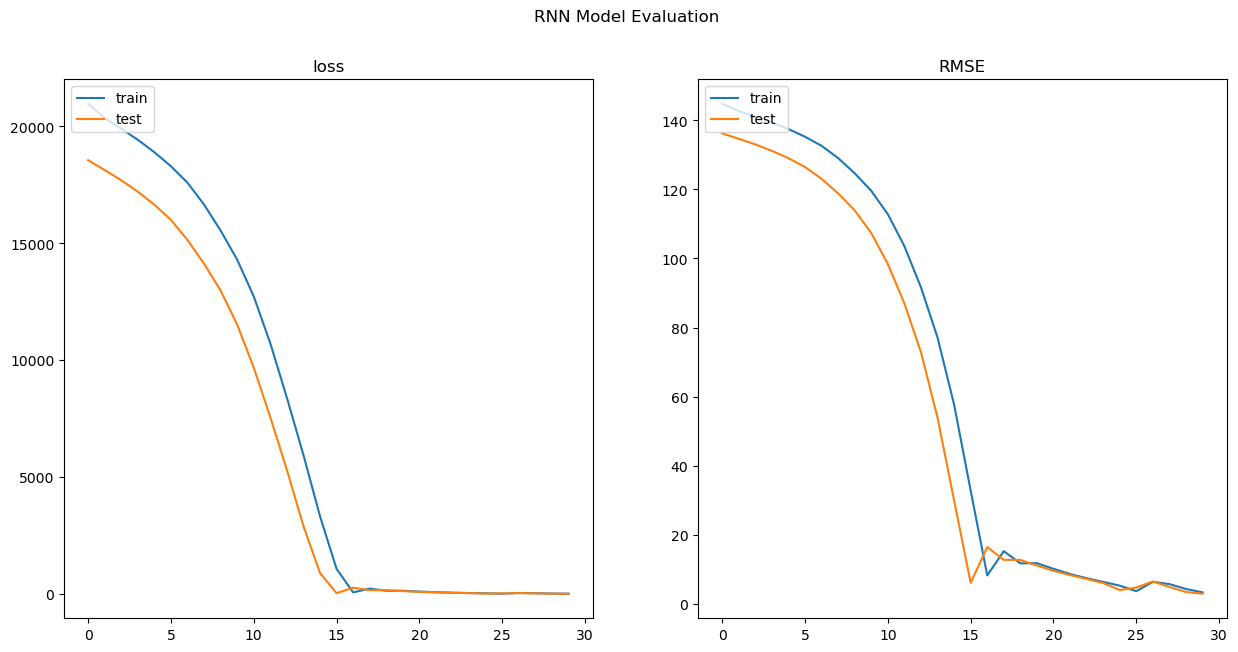

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [44]:
from sklearn.metrics import mean_squared_error

#Predict:
y_pred = model.predict(X_test)
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[143.70807],
       [153.40903],
       [107.91109],
       [175.4428 ],
       [131.31409],
       [128.26845],
       [158.8254 ],
       [117.04265]], dtype=float32)

In [45]:
mean_squared_error(y_test, y_pred)**0.5

2.8775483779061615

In [46]:
prior_days = np.array(
    [
        180.690002,182.410004,180,185.070007,185.190002,185.669998,185.949997,189.050003,186.130005, 
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 9, 1) # 1 row, 9 time steps (features), and 1 output/prediction)

In [47]:
model.predict(prior_days) # note the structure of the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step


array([[185.95122]], dtype=float32)

In [48]:
tomorrows_stock_price = model.predict(prior_days)[0][0] # we see the predicted price is embedded inside two dimensions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [49]:
print(f"Tomorrow's predicted stock price is {tomorrows_stock_price:.2f} dollar.")

Tomorrow's predicted stock price is 185.95 dollar.


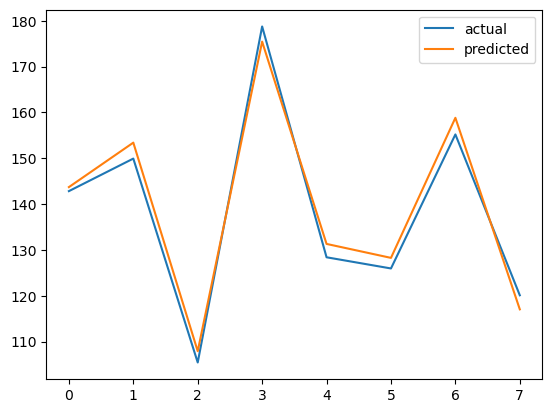

In [50]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

## MODEL04 - LSTM with Conv1D

In [51]:
n_steps = sequence_length - 1
n_inputs = 1


model = Sequential(
    [
        Conv1D(filters=10, kernel_size=3, strides=1, padding="valid", input_shape=[n_steps, n_inputs]),
        Conv1D(filters=10, kernel_size=3, strides=1, padding="valid"),
        LSTM(32, return_sequences=True, activation='relu'),
        LSTM(32, activation='relu'),
        Dense(1, activation=None)
    ]
)
model.summary()

/Users/xuesehuanghun/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 10)          │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 5, 10)          │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 32)          │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,207 (55.50 KB)

 Trainable params: 14,207 (55.50 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=epoch_num,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 23454.7207 - root_mean_squared_error: 153.1493 - val_loss: 20810.2363 - val_root_mean_squared_error: 144.2575
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 22833.9883 - root_mean_squared_error: 151.1092 - val_loss: 20419.1992 - val_root_mean_squared_error: 142.8958
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 22433.8926 - root_mean_squared_error: 149.7795 - val_loss: 20116.0391 - val_root_mean_squared_error: 141.8310
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 22077.8184 - root_mean_squared_error: 148.5861 - val_loss: 19814.1309 - val_root_mean_squared_error: 140.7627
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 21759.9219 - root_mean_squared_error: 147.5125 - val_loss: 19518.6094 - val_root_mean_squared_error: 139.7090
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 21431.7344 - root_mean_squared_error: 146.3958 - val_loss: 19119.3906 - val_root_mean_squared_error: 13

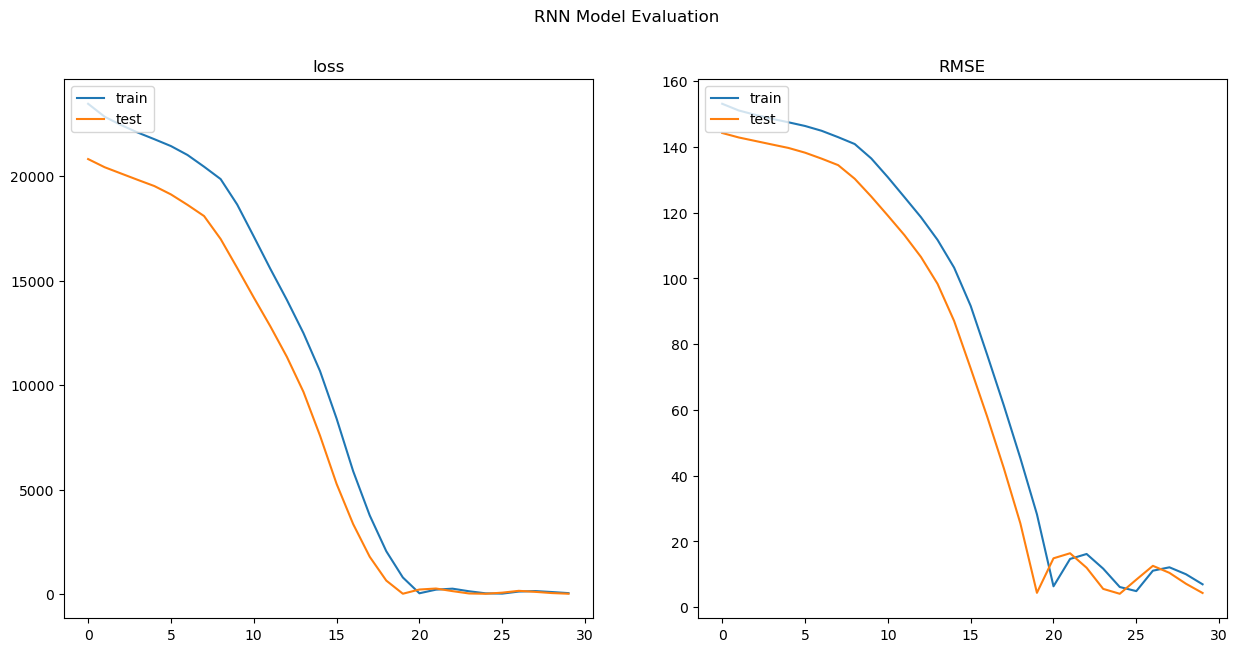

In [54]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [55]:
from sklearn.metrics import mean_squared_error

#Predict:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()  # Flatten y_pred to remove extra dimensions
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step


array([145.97285, 156.79823, 107.23511, 176.92148, 134.15462, 130.96198,
       159.99615, 118.9112 ], dtype=float32)

In [56]:
mean_squared_error(y_test, y_pred)**0.5

4.274284424586178

In [57]:
prior_days = np.array(
    [
        180.690002,182.410004,180,185.070007,185.190002,185.669998,185.949997,189.050003,186.130005, 
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 9, 1) # 1 row, 9 time steps (features), and 1 output/prediction)

In [58]:
model.predict(prior_days) # note the structure of the prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


array([[186.45901]], dtype=float32)

In [59]:
tomorrows_stock_price = model.predict(prior_days)[0][0] # we see the predicted price is embedded inside two dimensions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [60]:
print(f"Tomorrow's predicted stock price is {tomorrows_stock_price:.2f} dollar.")

Tomorrow's predicted stock price is 186.46 dollar.


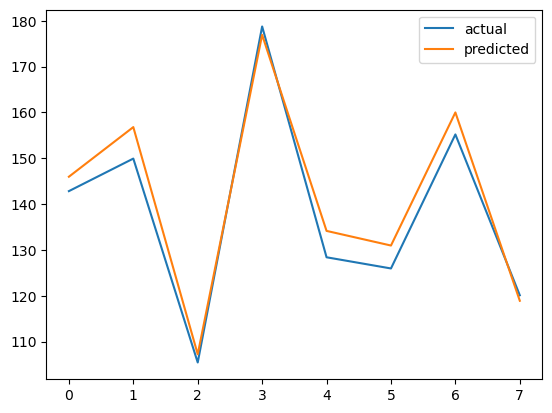

In [61]:
plt.plot(y_test, label = 'actual')
plt.plot(y_pred, label = 'predicted')

plt.legend()

plt.show()

## Summary

In this assignment, 4 different models will be applied (SimpleRNN, LSTM, GRU, and Conv1D) to predict the 10th-day closing stock price for Amazon using the past nine days' closing prices. Here's a summary of the performance of each model: 

Based on the provided results, let's analyze the performance of each model:

1. SimpleRNN:
   - RMSE: 5.0545
   - Predicted stock price: $190.83

2. LSTM:
   - RMSE: 3.7606
   - Predicted stock price: $186.85

3. GRU:
   - RMSE: 2.8775
   - Predicted stock price: $185.95

4. LSTM with Conv1D:
   - RMSE: 4.2743
   - Predicted stock price: $186.46

Based on the RMSE values, a lower RMSE indicates better performance in terms of predicting the 10th-day closing stock price. From the provided results, it appears that the GRU model performs the best among the models tested, as it has the lowest RMSE of 2.8775. The LSTM model also performs reasonably well but slightly worse than GRU, with an RMSE of 3.7606. The SimpleRNN model has the highest RMSE, indicating comparatively poorer performance. Finally, the performance of LSTM with Conv1D model lies between SimpleRNN and LSTM model, with RMSE of 4.2743, and shows some unstable features which means needs more tunes on that model.